In [ ]:
! unzip images

# AlexNet Model
Note: notebook can run all code needed for the model including predictions. Adjust files according to input path on your device. All files here are the same as the ones on the Kaggle database.
## Preprocessing Data

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [24]:
# Updated TPU detection and initialization
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Device:', tpu.master())
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)  # Updated to non-experimental TPUStrategy
except ValueError:
  strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
# Load Kaggle dataset
dataset = pd.read_csv('training.csv')

# In our dataset there are many missing values
# Take care of these missing values with the median
dataset.fillna(dataset.describe().T['50%'], inplace=True)
dataset.sample(5).T

,3118,4935,5072,3342,3690
left_eye_center_x,64.893569,67.950919,66.581673,63.450694,66.414558
left_eye_center_y,32.040533,37.702691,38.252989,40.412614,39.010885
right_eye_center_x,32.135219,31.778743,33.084764,27.765329,30.408203
right_eye_center_y,37.098816,38.219345,37.643956,36.214342,38.661363
left_eye_inner_corner_x,59.304615,59.304615,59.304615,59.304615,59.304615
left_eye_inner_corner_y,37.878040,37.878040,37.878040,37.878040,37.878040
left_eye_outer_corner_x,73.247824,73.247824,73.247824,73.247824,73.247824
left_eye_outer_corner_y,37.639015,37.639015,37.639015,37.639015,37.639015
right_eye_inner_corner_x,36.651562,36.651562,36.651562,36.651562,36.651562
right_eye_inner_corner_y,37.944075,37.944075,37.944075,37.944075,37.944075


In [37]:
# Create functions to load and show images
# sort_pattern: sorts for all the images 0.jpg to 7048.jpg
def sort_pattern(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

# load_images: load all the images from the path into an array
def load_images(path):
    images = []
    file_list = os.listdir(path)
    sorted_file = sorted(file_list, key=sort_pattern)

    for filename in sorted_file:
        if filename.endswith(".jpg"):
            img_path = os.path.join(path, filename)
            img = Image.open(img_path).convert('L')
            images.append(np.array(img))
            img.close()

    return images

# show_keypoints: print out a grid of plots with images that have the keypoints displayed
def show_keypoints(images, keypoints, n_rows=3, n_cols=7):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows), dpi=100)

    for i, ax in enumerate(axes.flatten()):
        img_array = np.array(images[i], dtype=np.uint8)
        img_array = img_array.squeeze()
        img = Image.fromarray(img_array)
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Sample #{i}')

        for j in range(0, len(keypoints[i]), 2):
            x = keypoints[i][j]
            y = keypoints[i][j + 1]
            ax.plot(x, y, 'ro', markersize=2)

    plt.tight_layout()
    plt.show()

def resize_images(images, target_size=(227, 227)):
    resized_images = []
    for img in images:
        pil_img = Image.fromarray(img)
        resized_img = np.array(pil_img.resize(target_size))
        resized_images.append(resized_img)
    return np.array(resized_images)

def undo_images(images, target_size=(96, 96)):
    resized_images = []
    for img in images:
        pil_img = Image.fromarray(img)
        resized_img = np.array(pil_img.resize(target_size))
        resized_images.append(resized_img)
    return np.array(resized_images)

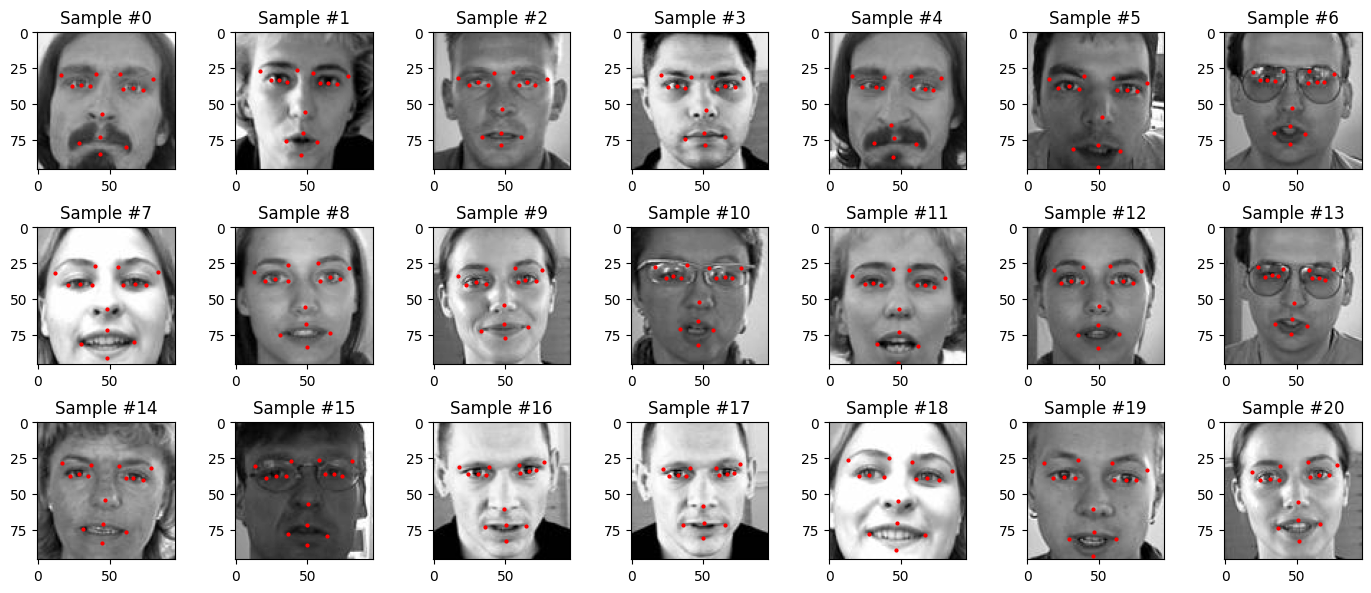

In [38]:
# Load the images from the path
# Depends on where you put the 7049 images in your device
path = r"train_images"
images = load_images(path)

# Show some examples
show_keypoints(images[:21], dataset.values[:21])

# Split the training and testing data
images = np.array(images).astype('float64')
data = dataset.values.astype('float64')
x_train, x_test, y_train, y_test = train_test_split(images, data, test_size=0.2, shuffle=False, random_state=21)

x_train = resize_images(x_train)
x_test = resize_images(x_test)

## Building the Model

In [39]:
with strategy.scope():
    def AlexNet(input_shape=(227, 227, 1), num_outputs=30):
        model = Sequential([
            # 1st Convolutional Layer
            Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu', input_shape=input_shape),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

            # 2nd Convolutional Layer
            Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

            # 3rd Convolutional Layer
            Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
            BatchNormalization(),

            # 4th Convolutional Layer
            Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
            BatchNormalization(),

            # 5th Convolutional Layer
            Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

            # Passing it to a Fully Connected layer
            Flatten(),

            # 1st Fully Connected Layer
            Dense(4096, activation='relu'),
            Dropout(0.5),
            BatchNormalization(),

            # 2nd Fully Connected Layer
            Dense(4096, activation='relu'),
            Dropout(0.5),
            BatchNormalization(),

            # Output Layer for Regression
            Dense(num_outputs)  # No activation function (linear)
        ])
        return model

    alexnet_model = AlexNet(input_shape=(227, 227, 1), num_outputs=30)
    alexnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        11712     
                                                                 
 batch_normalization_7 (Bat  (None, 55, 55, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_8 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                      

In [40]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)

reduce_LR = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              verbose=1,
                              mode='min',
                              min_lr=1e-9)

alexnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='mean_squared_error', metrics=['mae', 'acc'])

## Train the Model
We put the models to train for 100 epochs and included the early stopping and reducing of learning rate to control the training.

In [41]:
batch_size = 24 * strategy.num_replicas_in_sync
terminate_on_nan = tf.keras.callbacks.TerminateOnNaN()

history = alexnet_model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_LR, terminate_on_nan]
)

Epoch 1/100
235/235 [==============================] - 19s 66ms/step - loss: 154.7281 - mae: 7.1008 - acc: 0.4925 - val_loss: 146.4281 - val_mae: 8.1913 - val_acc: 0.1291 - lr: 0.0100
Epoch 2/100
235/235 [==============================] - 13s 54ms/step - loss: 22.4679 - mae: 3.4554 - acc: 0.5270 - val_loss: 15.2692 - val_mae: 2.5380 - val_acc: 0.4830 - lr: 0.0100
Epoch 3/100
235/235 [==============================] - 13s 55ms/step - loss: 17.2579 - mae: 2.9802 - acc: 0.5148 - val_loss: 6.6828 - val_mae: 1.5457 - val_acc: 0.5411 - lr: 0.0100
Epoch 4/100
235/235 [==============================] - 11s 48ms/step - loss: 13.7142 - mae: 2.5891 - acc: 0.5217 - val_loss: 7.3863 - val_mae: 1.7681 - val_acc: 0.4014 - lr: 0.0100
Epoch 5/100
235/235 [==============================] - 11s 49ms/step - loss: 12.1062 - mae: 2.3766 - acc: 0.5345 - val_loss: 5.8621 - val_mae: 1.4239 - val_acc: 0.5156 - lr: 0.0100
Epoch 6/100
235/235 [==============================] - 12s 50ms/step - loss: 11.0247 - mae:

## Results
Here are the graphs and results of the training

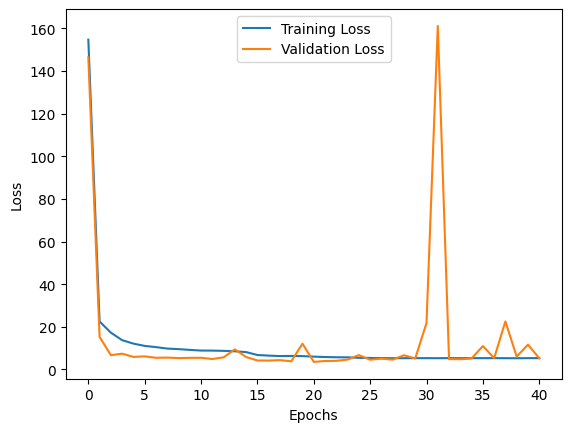

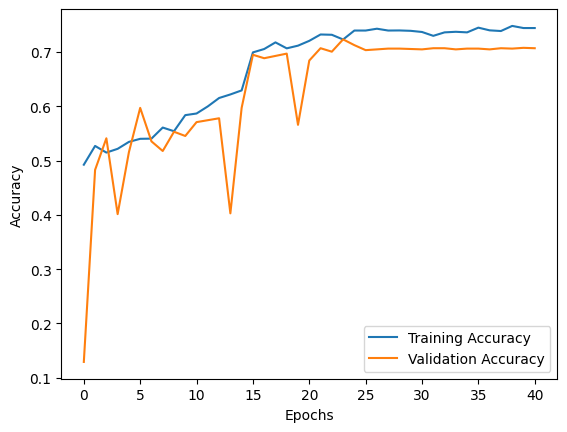

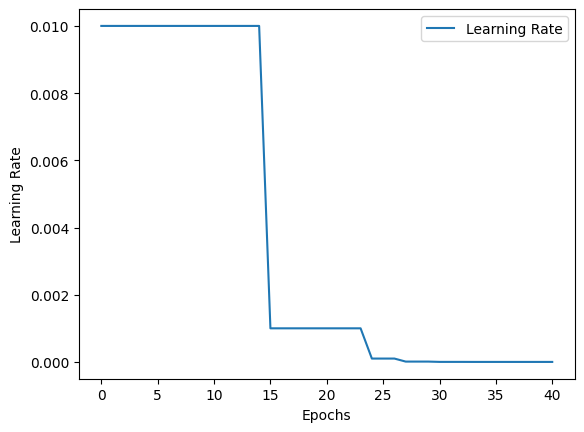

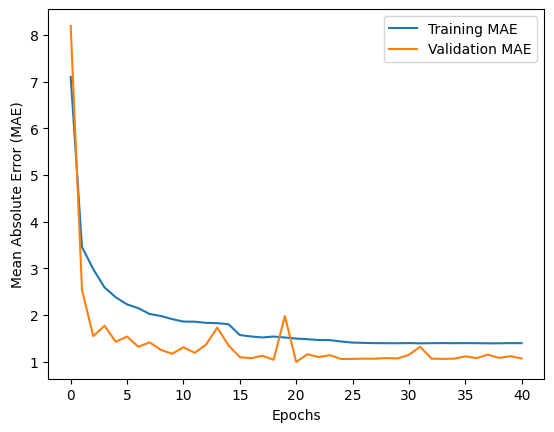

In [42]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot learning rate
plt.plot(history.history['lr'], label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

# Plot mean squared error
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()

## Predictions
Predict on the test images to see if the model does well. Also, calculate the mean squared error between the prediction and the actual values they are made of.

45/45 [==============================] - 1s 14ms/step


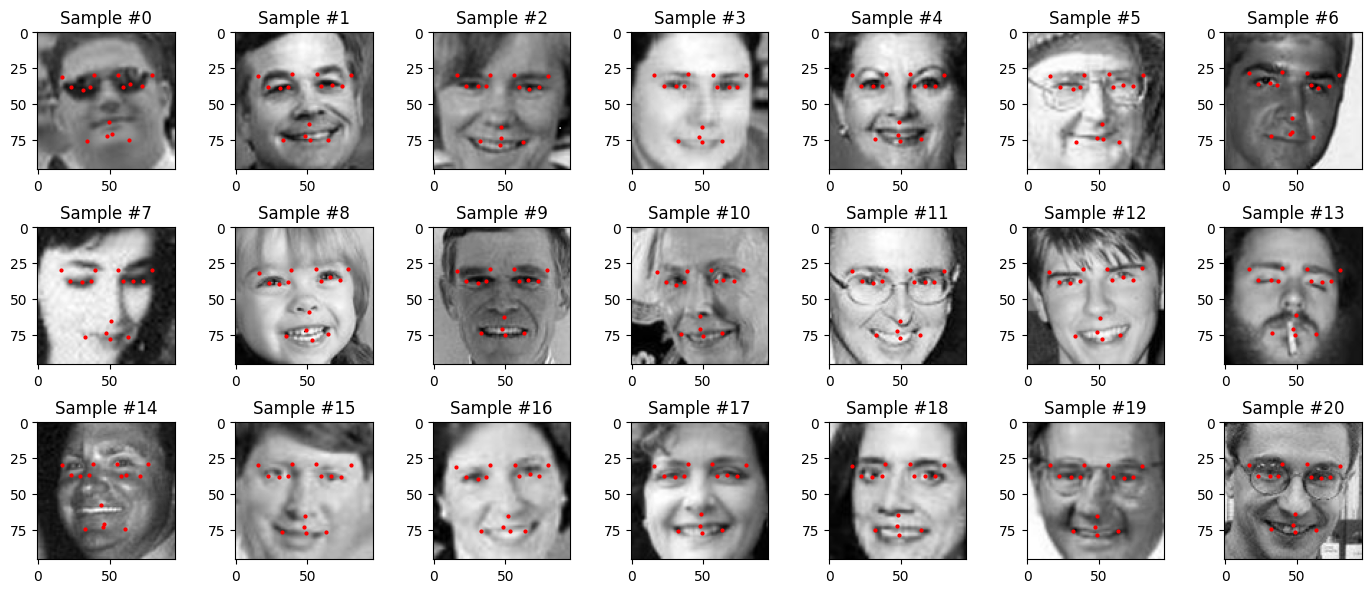

In [43]:
y_pred = alexnet_model.predict(x_test)

x_test = undo_images(x_test)
# Predicted points on the images
show_keypoints(x_test[:21], y_pred[:21])

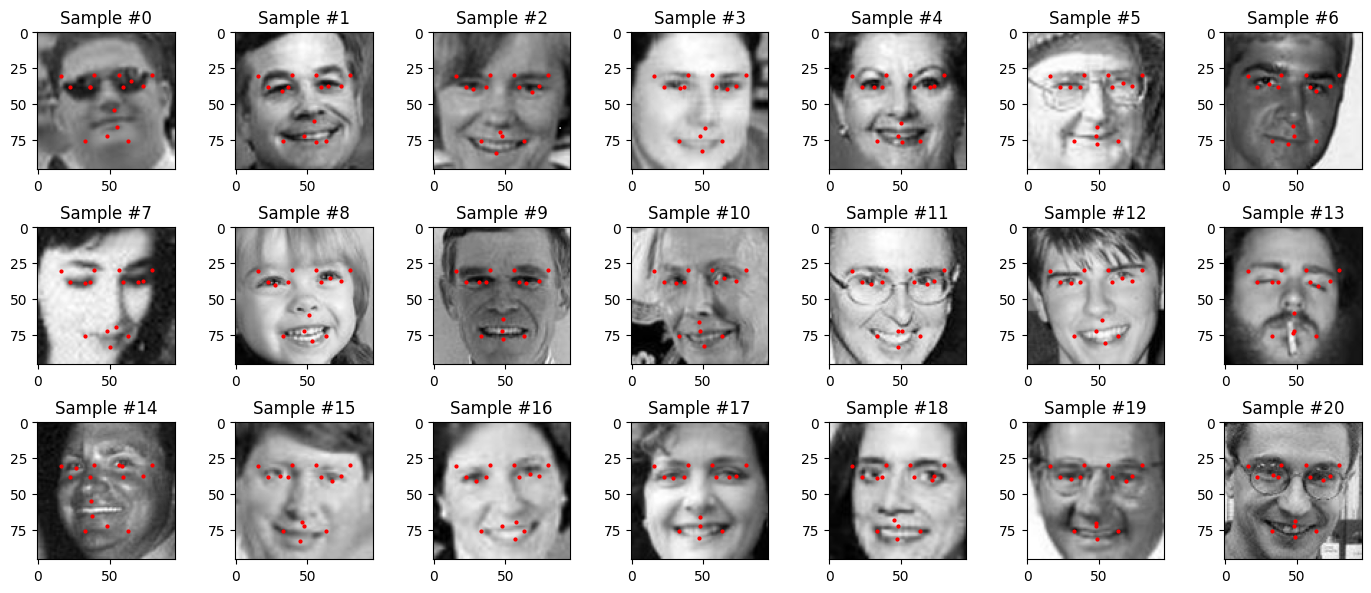

Mean Squared Error: 3.5139811087034554


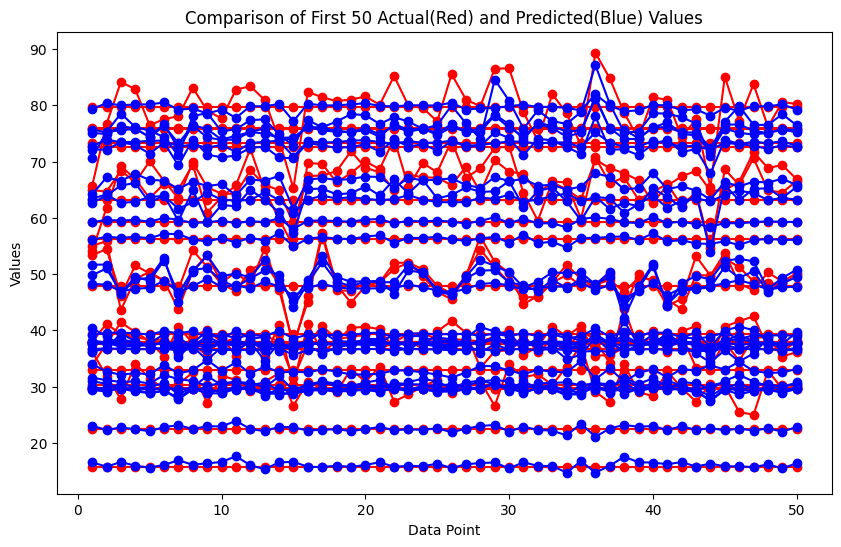

In [44]:
# Actual points on the same set of images
show_keypoints(x_test[:21], y_test[:21])

y_actual = np.array(y_test)
y_prediction = np.array(y_pred)
differences = y_actual - y_prediction
squared_differences = differences ** 2
mse = np.mean(squared_differences)
print("Mean Squared Error:", mse)

plt.figure(figsize=(10, 6))

plt.plot(range(1, 51), y_actual[:50], 'ro-', label='Actual')
plt.plot(range(1, 51), y_prediction[:50], 'bo-', label='Predicted')

# Customize the plot
plt.title('Comparison of First 50 Actual(Red) and Predicted(Blue) Values')
plt.xlabel('Data Point')
plt.ylabel('Values')
plt.show()